In [29]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import seaborn as sns
import sys
import scipy.stats as sc
import pandas as pd
import ffl

sys.path.append('../External_Functions')
from ExternalFunctions import UnbinnedLH, Chi2Regression, BinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax  # Useful functions to print fit results on figure

sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('deep', 10, desat = 1)
sns.set_palette(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['figure.figsize'] = (16, 9)


In [30]:
df = pd.read_csv('data_SignalDetection.csv', header=0)
index, P, R, freq, type = df.values.T
df


,Index,Phase,Resonance,Frequency,Type
0,1.0,6.41748,1.35986,2.29355,0.0
1,2.0,2.83297,2.88136,0.95732,0.0
2,3.0,5.13004,11.45223,1.41931,1.0
3,4.0,9.60038,10.35148,0.68279,0.0
4,5.0,7.17903,4.45108,2.74433,0.0
...,...,...,...,...,...
119995,119996.0,4.25885,-0.08775,5.96166,-1.0
119996,119997.0,6.45887,4.62049,3.77644,-1.0
119997,119998.0,0.53238,-2.07295,0.40504,-1.0
119998,119999.0,1.94328,8.69095,0.00043,-1.0


# 5.1 

The file www.nbi.dk/∼petersen/data SignalDetection.csv contains 120000 entries with values of phase (P), resonance (R), frequency (ν), and type. In the first 100000 entries
(control sample) it is known if the measurements are signal (1) or noise (0). In the last 20000
entries (real sample) this is unknown.

## 5.1.1

Plot the control sample frequency distribution. Fit the observed H-peak at ν = 1.42 GHz.

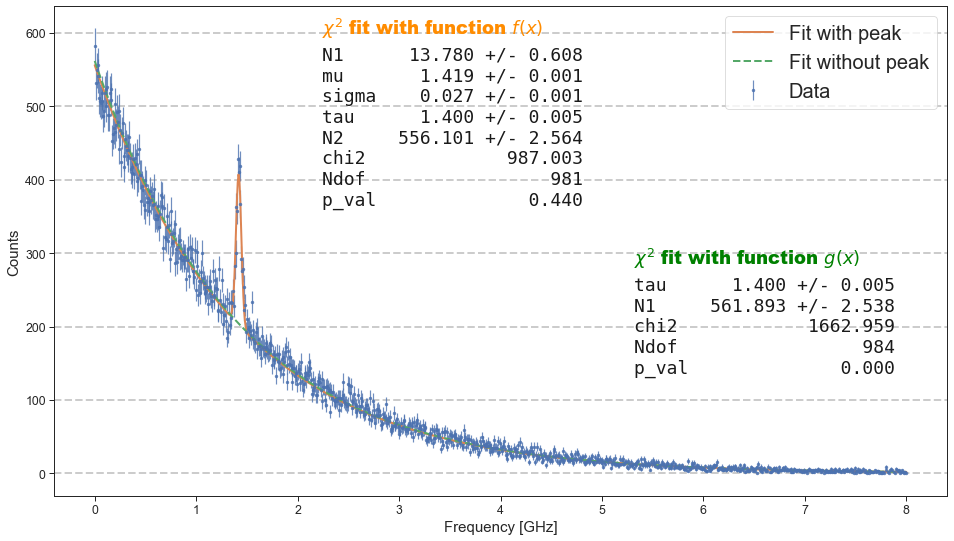

In [31]:
peak = 1.42

cont_freq = freq[:100000]

hist_range = [0, 8]
Nbins = 1000
fig, ax = plt.subplots()

# ax.hist(cont_freq, bins=Nbins,range=hist_range, histtype='step', label='Continuous Frequency')

binmids, counts, err_counts = ffl.hist_for_fit(cont_freq, Nbins, hist_range)
ax.errorbar(binmids, counts, yerr=err_counts, fmt='.', label='Data', alpha=0.8)

def fit_function(x, N1, mu, sigma , tau, N2,):
    return N1 * ffl.gauss(x, mu, sigma) + N2 * np.exp(-x/tau)

def exp(x, tau, N1):
    return N1 * np.exp(- x / tau)

peak_fit, Ndof, p_val, par_dict = ffl.fit_with_chi2(fit_function, binmids, counts, err_counts, [1000, peak, 0.1, 1, 10])
x_fit = np.linspace(hist_range[0], hist_range[1], 1000)
y_fit = fit_function(x_fit, *peak_fit.values[:])

par_string = nice_string_output(par_dict, extra_spacing=2, decimals=3)
add_text_to_ax(0.3, 0.92, par_string, ax, fontsize=18)

no_peak_fit, Ndof, p_val, par_dict = ffl.fit_with_chi2(exp, binmids, counts, err_counts, [1, 300])
y_fit_no_peak = exp(x_fit, *no_peak_fit.values[:])

no_peak_string = nice_string_output(par_dict, extra_spacing=2, decimals=3)
add_text_to_ax(0.65, 0.45, no_peak_string, ax, fontsize=18)

ax.plot(x_fit, y_fit, label='Fit with peak', linewidth=2)
ax.plot(x_fit, y_fit_no_peak, label='Fit without peak', ls='--',linewidth=2)

# Adding big text to figures
ax.text(0.3, 0.98, r'$\chi^2$ fit with function $f(x)$', weight='heavy', fontsize=18, transform=ax.transAxes, 
        verticalalignment='top', color='darkorange');

ax.text(0.65, 0.51, r'$\chi^2$ fit with function $g(x)$', weight='heavy', fontsize=18, transform=ax.transAxes, 
        verticalalignment='top', color='green');

ax.set_xlabel('Frequency [GHz]', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.legend( loc='upper right', fontsize=20)

plt.savefig('saved_images/5_1_1.png')

## 5.1.2

Quantify how well you can separate signal from noise using the variables P and R.

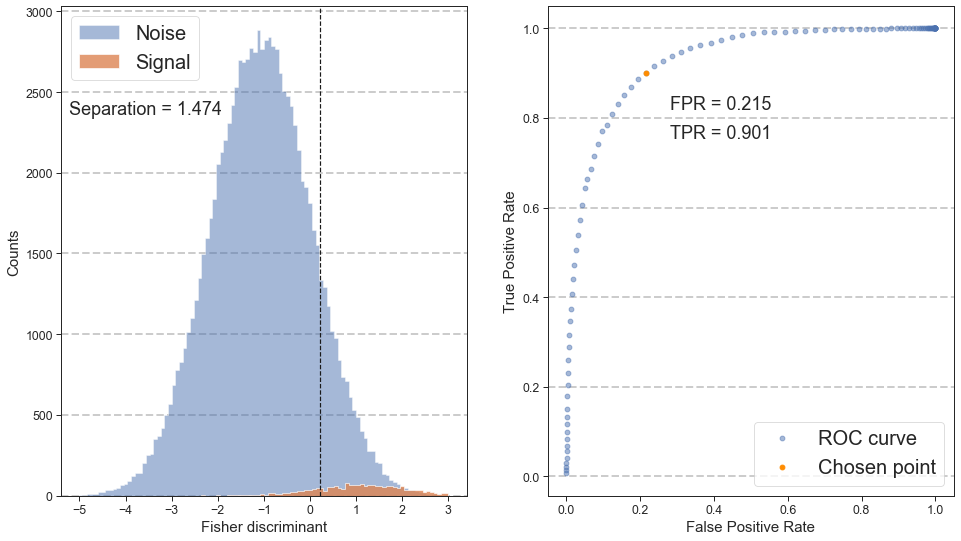

In [32]:
# Get all data from dataframe where type == 1
signal_list = df[df['   Type'] == 1].values

# Get all data from dataframe where type == 0
noise_list = df[df['   Type'] == 0].values

signal = signal_list[:, 1:3]
noise = noise_list[:, 1:3]
signal = np.array(signal, dtype=float)
noise = np.array(noise, dtype=float)

fisher_signal, fisher_noise, wf = ffl.easy_fisher(signal, noise)

Nbins = 100
hist_range = [-5, 3]

fig, ax = plt.subplots(1,2)
noise_hist = ax[0].hist(fisher_noise, bins=Nbins, range=hist_range, histtype='stepfilled', label='Noise', alpha=0.5);
signal_hist = ax[0].hist(fisher_signal, bins=Nbins, range=hist_range, histtype='stepfilled', label='Signal', alpha=0.8);

FPR, TPR = ffl.calc_ROC(signal_hist, noise_hist)
TPR = np.sort(TPR)
FPR = np.sort(FPR)

sep = ffl.sep_calc(fisher_signal, fisher_noise)
ax[0].text(0.02, 0.78, r'Separation = {:.3f}'.format(sep), fontsize=18, transform=ax[0].transAxes)
ax[0].set_xlabel('Fisher discriminant', fontsize=15)
ax[0].set_ylabel('Counts', fontsize=15)
ax[0].legend(loc='upper left', fontsize=20)

ax[1].plot(FPR, TPR, label='ROC curve', marker='o', ls='', alpha=0.5)
ax[1].set_xlabel('False Positive Rate', fontsize=15)
ax[1].set_ylabel('True Positive Rate', fontsize=15)

# Chose a point on the ROC curve where TPR is closest to  0.9

ind_90 = np.where(TPR > 0.9)[0][0]

ax[1].plot(FPR[ind_90], TPR[ind_90], marker='o', color='darkorange', label='Chosen point', ls='')

ax[1].text(0.3, 0.79, r'FPR = {:.3f}'.format(FPR[ind_90]), fontsize=18, transform=ax[1].transAxes)
ax[1].text(0.3, 0.73, r'TPR = {:.3f}'.format(TPR[ind_90]), fontsize=18, transform=ax[1].transAxes)
ax[1].legend(loc='lower right', fontsize=20)

# mark the point on the histogram
ax[0].axvline(FPR[ind_90], color='k', ls='--', label='Chosen point')

plt.savefig('saved_images/5_1_2.png')


## 5.1.3    
Selecting entries based only on P and R, how significant can you get the H-peak fit to be?

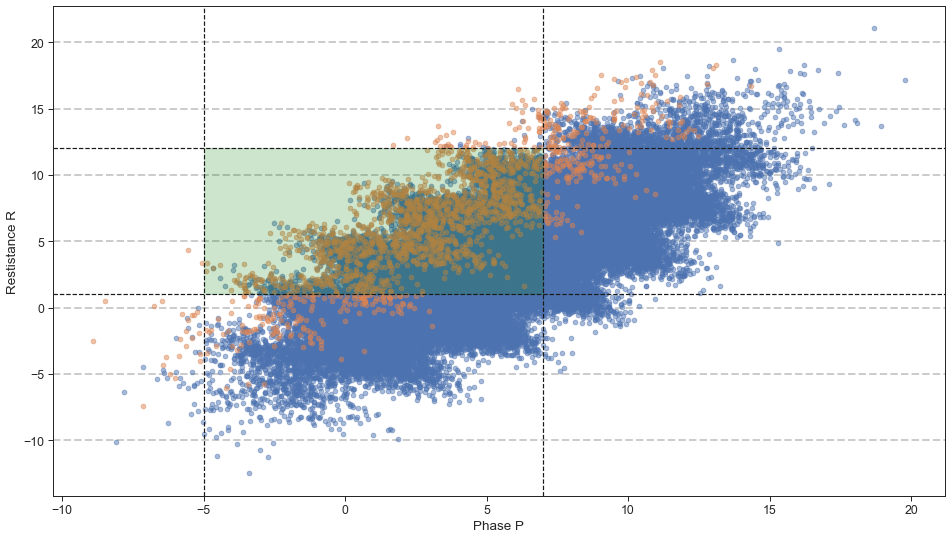

In [33]:
noise_id = np.where(type == 0)[0]
signal_id = np.where(type == 1)[0]

R_noise = R[noise_id]
R_signal = R[signal_id]

P_noise = P[noise_id]
P_signal = P[signal_id]

fig, ax = plt.subplots()
ax.scatter(P_noise, R_noise, label='Noise', alpha=0.5)
ax.scatter(P_signal, R_signal, label='Signal', alpha=0.5)
ax.set_xlabel('Phase P')
ax.set_ylabel('Restistance R')

# makring quadrant from p = [-5, 7] and r = [1, 12]
ax.axvline(-5, color='k', ls='--')
ax.axvline(7, color='k', ls='--')
ax.axhline(1, color='k', ls='--')
ax.axhline(12, color='k', ls='--')

# fill square with green
ax.fill_between([-5, 7], [1, 1], [12, 12], color='green', alpha=0.2, label='Signal region')

plt.savefig('saved_images/5_1_3_1.png')

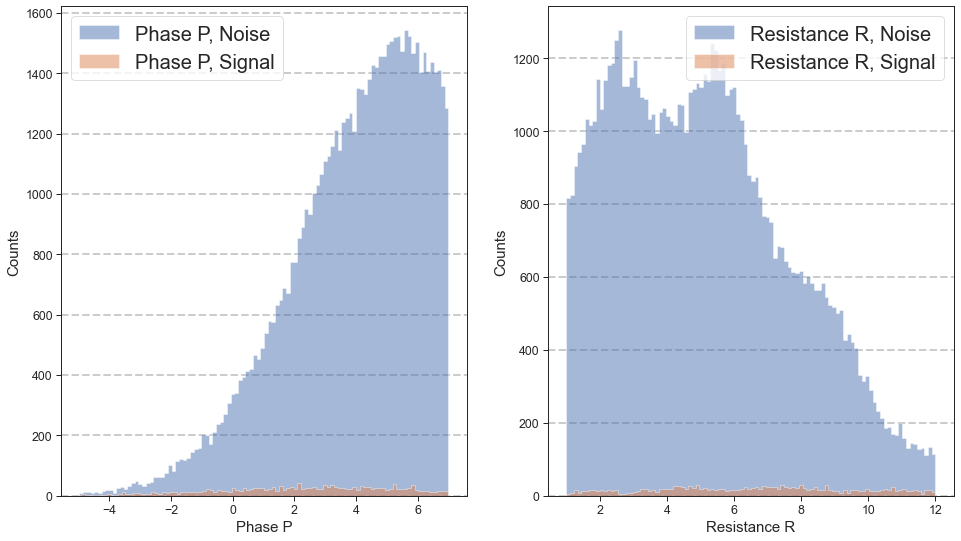

In [34]:
mask_P = (P > -5) & (P < 7)
mask_R = (R > 1) & (R < 12)

masked_P = P[mask_P]
masked_R = R[mask_R]

masked_P_sig = P[mask_P & (type == 1)]
masked_R_sig = R[mask_R & (type == 1)]
masked_P_noise = P[mask_P & (type == 0)]
masked_R_noise = R[mask_R & (type == 0)]


fig, ax = plt.subplots(1,2)
ax[0].hist(masked_P_noise, bins=100, histtype='stepfilled', label='Phase P, Noise', alpha=0.5);
ax[0].hist(masked_P_sig, bins=100, histtype='stepfilled', label='Phase P, Signal', alpha=0.5);
ax[0].set_xlabel('Phase P', fontsize=15)
ax[0].set_ylabel('Counts', fontsize=15)
ax[0].legend(loc='upper left',  fontsize=20)


ax[1].hist(masked_R_noise, bins=100, histtype='stepfilled', label='Resistance R, Noise', alpha=0.5);
ax[1].hist(masked_R_sig, bins=100, histtype='stepfilled', label='Resistance R, Signal', alpha=0.5);
ax[1].set_xlabel('Resistance R', fontsize=15)
ax[1].set_ylabel('Counts', fontsize=15)
ax[1].legend(loc='upper right', fontsize=20)

plt.savefig('saved_images/5_1_3_2.png')

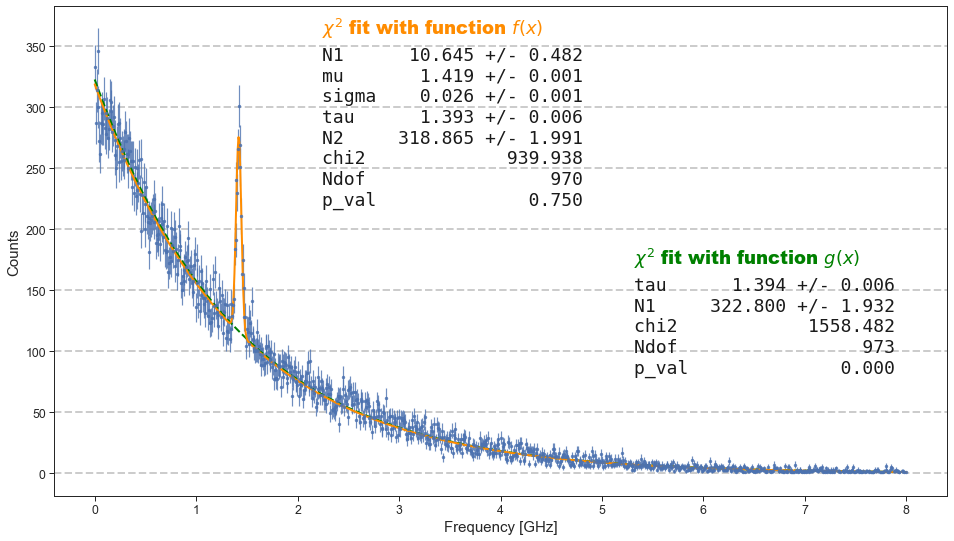

In [35]:

freq_masked = freq[mask_P & mask_R]

N_bins = 1000
hist_range = [0,8]

binmids_masked, counts_masked, err_counts_masked = ffl.hist_for_fit(freq_masked, N_bins, hist_range)

chi2_peak, Ndof_peak, pval_peak, par_dict_peak = ffl.fit_with_chi2(fit_function, binmids_masked, counts_masked, err_counts_masked, [1000, peak, 0.1, 1, 10])
chi2_no_peak, Ndof_no_peak, pval_no_peak, par_dict_no_peak = ffl.fit_with_chi2(exp, binmids_masked, counts_masked, err_counts_masked, [1, 300])

x_fit = np.linspace(hist_range[0], hist_range[1], 1000)
y_peak = fit_function(x_fit, *chi2_peak.values[:])
y_no_peak = exp(x_fit, *chi2_no_peak.values[:])

fig, ax = plt.subplots()
ax.errorbar(binmids_masked, counts_masked, yerr=err_counts_masked, fmt='.', label='Data', alpha=0.8)


ax.text(0.3, 0.98, r'$\chi^2$ fit with function $f(x)$', weight='heavy', fontsize=18, transform=ax.transAxes, 
        verticalalignment='top', color='darkorange');

ax.text(0.65, 0.51, r'$\chi^2$ fit with function $g(x)$', weight='heavy', fontsize=18, transform=ax.transAxes, 
        verticalalignment='top', color='green');

ax.plot(x_fit, y_no_peak, label='Fit without peak', color = 'green', ls='--',linewidth=2)
ax.plot(x_fit, y_peak, label='Fit with peak', color = 'darkorange', linewidth=2)


string_peak = nice_string_output(par_dict_peak, extra_spacing=2, decimals=3)
string_no_peak = nice_string_output(par_dict_no_peak, extra_spacing=2, decimals=3)

add_text_to_ax(0.3, 0.92, string_peak, ax, fontsize=18)
add_text_to_ax(0.65, 0.45, string_no_peak, ax, fontsize=18)

ax.set_xlabel('Frequency [GHz]', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)


plt.savefig('saved_images/5_1_3_3.png')

## 5.1.4

Plot the real data frequency distribution, and search for a peak in the range [0.1,1.0] GHz.


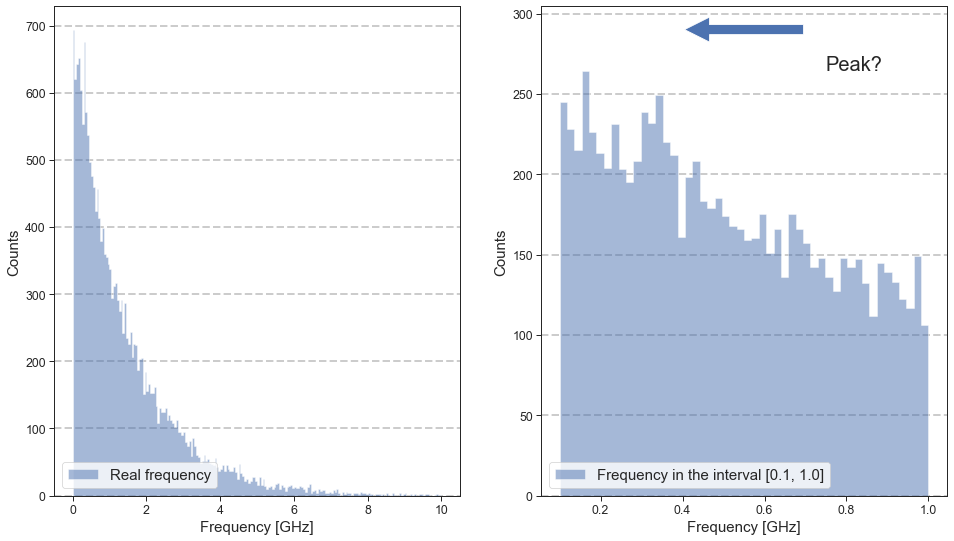

In [36]:
# Real frequency data (type == -1)
real_freq = freq[type == -1]
slicing = (real_freq > 0.1) & (real_freq < 1)
sliced_freq = real_freq[slicing]

hist_range_l = [0,10]
hist_range_s = [0.1,1]
bins_l = 200
bins_s = 50

fig, ax = plt.subplots(1,2)
ax[0].hist(real_freq, bins = bins_l, range = hist_range_l, histtype='stepfilled', label='Real frequency', alpha=0.5);
ax[0].set_xlabel('Frequency [GHz]', fontsize=15)
ax[0].set_ylabel('Counts', fontsize=15)
ax[0].legend(loc='lower left', fontsize=15)

ax[1].hist(sliced_freq, bins=bins_s, range=hist_range_s, histtype='stepfilled', label='Frequency in the interval [0.1, 1.0]', alpha=0.5);
ax[1].set_xlabel('Frequency [GHz]', fontsize=15)
ax[1].set_ylabel('Counts', fontsize=15)
ax[1].legend(loc='lower left', fontsize=15)

import matplotlib.patches as mpatches
x_tail = 0.7
y_tail = 290
x_head = 0.4
y_head = 290
dx = x_head - x_tail
dy = y_head - y_tail

arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 mutation_scale=50)
ax[1].add_patch(arrow)

ax[1].text(0.7, 0.87, 'Peak?', fontsize=20, transform=ax[1].transAxes)

plt.savefig('saved_images/5_1_4.png')

## 5.1.5
How many signal entries do you estimate there to be in the peak? Do you find it significant?

By eyeballing I would say that five bins are contained in the peak with around 250-300 counts in each. But we need more than eyeballing: let's do the same fit as before and find out, if the peak is significant in relation to what must be asumed to be background. 


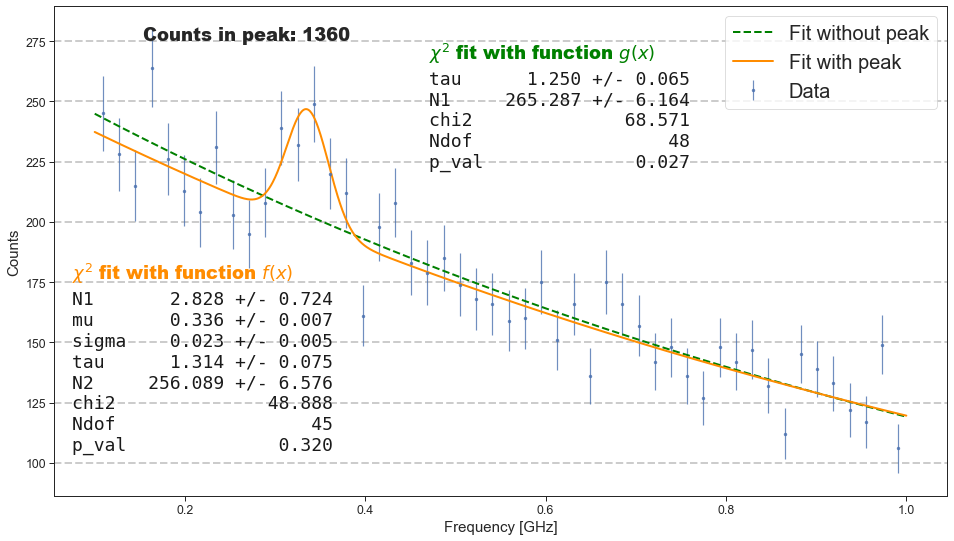

In [37]:
bins_s = 50
binmids, counts, err_counts = ffl.hist_for_fit(sliced_freq, bins_s, hist_range_s)

chi2_peak, Ndof_peak, pval_peak, par_dict_peak = ffl.fit_with_chi2(fit_function, binmids, counts, err_counts, [10, 0.35, 0.01, 1.3, 300])
chi2_no_peak, Ndof_no_peak, pval_no_peak, par_dict_no_peak = ffl.fit_with_chi2(exp, binmids, counts, err_counts, [1.3, 300])

x_fit = np.linspace(hist_range_s[0], hist_range_s[1], 1000)
y_peak = fit_function(x_fit, *chi2_peak.values[:])
y_no_peak = exp(x_fit, *chi2_no_peak.values[:])

fig, ax = plt.subplots()
ax.errorbar(binmids, counts, yerr=err_counts, fmt='.', label='Data', alpha=0.8)

ax.plot(x_fit, y_no_peak, label='Fit without peak', color = 'green', ls='--',linewidth=2)
ax.plot(x_fit, y_peak, label='Fit with peak', color = 'darkorange', linewidth=2)

ax.text(0.02, 0.48, r'$\chi^2$ fit with function $f(x)$', weight='heavy', fontsize=18, transform=ax.transAxes, 
        verticalalignment='top', color='darkorange');

ax.text(0.42, 0.93, r'$\chi^2$ fit with function $g(x)$', weight='heavy', fontsize=18, transform=ax.transAxes, 
        verticalalignment='top', color='green');

string_peak = nice_string_output(par_dict_peak, extra_spacing=2, decimals=3)
string_no_peak = nice_string_output(par_dict_no_peak, extra_spacing=2, decimals=3)

add_text_to_ax(0.02, 0.42, string_peak, ax, fontsize=18)
add_text_to_ax(0.42, 0.87, string_no_peak, ax, fontsize=18)

ax.set_xlabel('Frequency [GHz]', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.legend(loc='upper right', fontsize=20)

peak_counts = counts[10:16]
sum_counts = np.sum(peak_counts)

ax.text(0.1, 0.93, f'Counts in peak: {sum_counts}', fontsize=18, transform=ax.transAxes, weight='heavy')

plt.savefig('saved_images/5_1_5.png')


## 5.1.6

Correcting for the signal selection efficiency when using P and R, how many signal entries
do you estimate there was in the data originally?


In [41]:
# Calculate estimated number of counts according to exponential fit
counts_exp = exp(binmids, *chi2_no_peak.values[:])
counts_exp_peak = counts_exp[10:16]

est_count = sum_counts - np.sum(counts_exp_peak)
print(est_count)

141.21942789399304
